## Model selection

### Problem:

A statistician observes data $x$ and wishes to choose between a smaller model $\mathcal{M}_0$ and a larger model $\mathcal{M}_1$.
Textbook example:

- $x=(x_1,...,x_n)$ drawn from $x_i\stackrel{\text{iid}}{\sim} \mathcal{N}(\mu,1)$. 
- $\mathcal{M}_0$ is the null hypothesis $\mu=0$ and
- $\mathcal{M}_1$ the alternative: $\mathcal{M}_1~:~\mu\neq 0$. 


### Setup

1. **Data Setup**:
    - `n` is the number of observed data points.
    - `sample_mean` is the mean of the observed data.
    - `sample_variance` is the unbiased sample variance (since `ddof=1` is used).

2. **Likelihood under $M_0$ (Null Hypothesis)**:
    - Under the null hypothesis $M_0$, the mean $\mu$ is assumed to be zero ($ \mu = 0$).
    - The likelihood of observing the data if $M_0$ is true is computed as the product of the probability density function (PDF) values of the normal distribution with mean $0$ and standard deviation $1$ for each data point.

$$ \text{likelihood}_{M_0} = \prod_{i=1}^{n} \phi(x_i | \mu=0, \sigma^2=1),$$
where $\phi$ is the PDF of the normal distribution, and $x_i$ are the observed data points.

3. **Marginal Likelihood under $M_1$ (Alternative Hypothesis)**:
    - Under the alternative hypothesis $M_1$, the mean $\mu$ is unknown and is being integrated out (treated as a random variable with its own prior distribution).
    - A function `integrand` is defined to calculate the product of the likelihood of the data given $\mu$ and the prior probability of $\mu$.
    - This function is then integrated over all possible values of $\mu$ to calculate the marginal likelihood of $M_1$. This integrates out the parameter $\mu$, taking into account all possible values it could take according to the prior distribution.

$$\text{marginal_likelihood}_{M_1} = \int_{-\infty}^{\infty} \left(\prod_{i=1}^{n} \phi(x_i | \mu, \sigma^2=1) \right) \phi(\mu | \mu=0, \sigma^2=\text{prior_variance}) d\mu,$$
where $\phi(\mu | \mu=0, \sigma^2=\text{prior_variance})$ is the prior distribution of $\mu$ under $M_1$.

4. **Bayes Factor**:
    - The Bayes Factor is calculated by dividing the marginal likelihood of $M_1$ by the likelihood of $M_0$.

$$\text{Bayes Factor} = \frac{\text{marginal_likelihood}_{M_1}}{\text{likelihood}_{M_0}} $$


A Bayes Factor greater than 1 indicates that the data are more likely under $M_1$ than $M_0$, and a Bayes Factor less than 1 indicates the opposite.

5. **Running the Test**:
    - Synthetic data are generated with a known mean $\mu = 0.5$ and standard deviation $ 1 $.
    - The Bayes Factor is calculated using this data.



In [18]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

def calculate_bayes_factor(data, prior_variance=1):
    n = len(data)
    sample_mean = np.mean(data)
    sample_variance = np.var(data, ddof=1)
    
    # Under M0 (mu=0), the likelihood of the data is simply the product of n normal PDFs
    likelihood_M0 = np.prod(norm.pdf(data, loc=0, scale=1))
    
    # Calculate the marginal likelihood under M1 (integrating out mu)
    def integrand(mu):
        likelihood = np.prod(norm.pdf(data, loc=mu, scale=1))
        prior = norm.pdf(mu, loc=0, scale=np.sqrt(prior_variance))
        return likelihood * prior
    
    marginal_likelihood_M1, _ = quad(integrand, -np.inf, np.inf)
    
    # Calculate Bayes factor
    bayes_factor = marginal_likelihood_M1 / likelihood_M0
    
    return bayes_factor

# Generate synthetic data (n samples from a normal distribution)
np.random.seed(42)
n = 10
mu = .2  # True mean of the distribution
data = np.random.normal(loc=mu, scale=1, size=n)

# Calculate Bayes factor
bayes_factor = calculate_bayes_factor(data, prior_variance=1)
sample_mean = np.mean(data)
sample_variance = np.var(data, ddof=1)
print("Sample mean:", sample_mean)
print("Sample variance:", sample_variance)
print("Bayes Factor:", bayes_factor)

# Interpretation
if bayes_factor > 1:
    print("Evidence in favor of the alternative hypothesis (mu ≠ 0)")
elif bayes_factor < 1:
    print("Evidence in favor of the null hypothesis (mu = 0)")
else:
    print("Data do not favor one hypothesis over the other")


Sample mean: 0.6480611116987562
Sample variance: 0.5227410502368408
Bayes Factor: 2.03612756046979
Evidence in favor of the alternative hypothesis (mu ≠ 0)


Lets plot this scenario to get a sense of what is going on

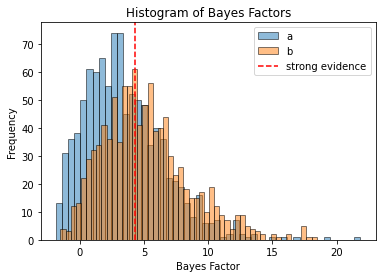

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

def run_experiment(num_experiments, n, mu, prior_variance):
    bayes_factors = []
    np.random.seed(42)
    for _ in range(num_experiments):
        data = np.random.normal(loc=mu, scale=1, size=n)
        bayes_factor = calculate_bayes_factor(data, prior_variance=prior_variance)
        bayes_factors.append(bayes_factor)
    return bayes_factors

# Experiment parameters
num_experiments = 1000
mu = 0.5
prior_variance = 1

# Run experiments
bayes_factors_a = run_experiment(num_experiments, n=40, mu=.5, prior_variance=prior_variance)
bayes_factors_b = run_experiment(num_experiments, n=20, mu=.8, prior_variance=prior_variance)

# Plot histograms
plt.hist(np.log(bayes_factors_a), bins=50, alpha=0.5, label='a', edgecolor='k')
plt.hist(np.log(bayes_factors_b), bins=50, alpha=0.5, label='b', edgecolor='k')
plt.axvline(x=np.log(75), color='r', linestyle='--', label='strong evidence')
plt.xlabel('Bayes Factor')
plt.ylabel('Frequency')
plt.title('Histogram of Bayes Factors')
plt.legend()
plt.show()



# Objective Bayes and MCMC

Sample mean 4.792306965211812
Sample variance 3.266088778775434


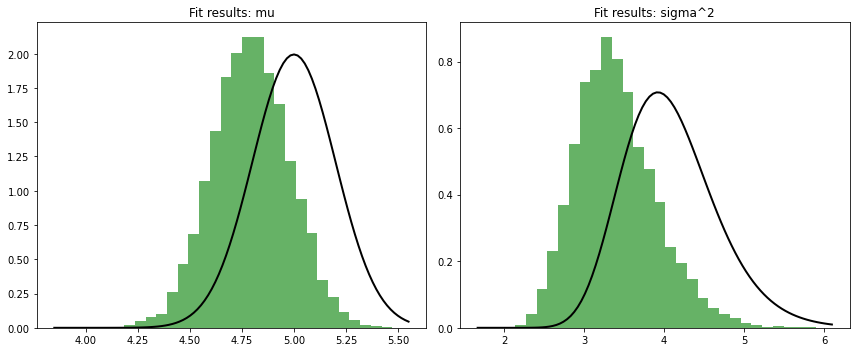

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

# Generate synthetic data
np.random.seed(42)
n = 100  # number of data points
mu_true = 5
sigma_true = 2
data = np.random.normal(mu_true, sigma_true, n)

# Objective Bayes method with MCMC Gibbs sampling
iterations = 10000
burn_in = 2000

# Initialize parameters
mu = np.mean(data)
sigma2 = np.var(data)

print("Sample mean", mu)
print("Sample variance", sigma2)

# Arrays to store samples
mu_samples = np.zeros(iterations)
sigma2_samples = np.zeros(iterations)

# Gibbs Sampling
for i in range(iterations):
    # Sample from the conditional posterior of mu
    mu_mean = np.mean(data)
    mu_var = sigma2 / n
    mu = np.random.normal(mu_mean, np.sqrt(mu_var))
    
    # Sample from the conditional posterior of sigma2
    alpha = (n - 1) / 2
    beta = 0.5 * np.sum((data - mu)**2)
    sigma2 = 1 / np.random.gamma(alpha, 1 / beta)
    
    # Store samples
    mu_samples[i] = mu
    sigma2_samples[i] = sigma2

# Discard burn-in samples
mu_samples = mu_samples[burn_in:]
sigma2_samples = sigma2_samples[burn_in:]

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_true, np.sqrt(sigma_true**2/n))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Fit results: mu')

plt.subplot(1, 2, 2)
plt.hist(sigma2_samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = invgamma.pdf(x, (n-1)/2, scale=(n-1)*sigma_true**2/2)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Fit results: sigma^2')

plt.tight_layout()
plt.show()


## Extended example


This is a concrete example in educational testing, where you are interested in estimating a students' abilities based on their responses to questions, while also accounting for the varying difficulties of the questions. This is known as Item Response Theory (IRT).

### Hierarchical Bayesian IRT Model

The hierarchical Bayesian IRT model can be described as follows:

1. **Student Ability Level ($\theta_i$)**: For each student $i$, we want to estimate their ability level $\theta_i$. This is modeled as a normally distributed random variable.
  
   $$\theta_i \sim \mathcal{N}(\mu_\theta, \sigma^2_\theta)$$

2. **Question Difficulty ($\beta_j$)**: For each question $j$, we want to estimate its difficulty level $\beta_j$. This is also modeled as a normally distributed random variable.
  
   $$\beta_j \sim \mathcal{N}(\mu_\beta, \sigma^2_\beta)$$

3. **Student Responses ($Y_{ij}$)**: The response of student $i$ to question $j$ is modeled as a Bernoulli random variable, with the probability of a correct answer depending on the student’s ability and the question’s difficulty.
  
   $$P(Y_{ij} = 1) = \text{logit}^{-1}(\theta_i - \beta_j)$$

   where $\text{logit}^{-1}(x) = \frac{1}{1 + e^{-x}}$

4. **Priors for Hyperparameters**: Priors need to be specified for the hyperparameters $\mu_\theta, \sigma^2_\theta, \mu_\beta, \sigma^2_\beta$. These are typically set to be weakly informative or non-informative to let the data speak for itself.

### MCMC for Parameter Estimation

Once the model is specified, MCMC can be used to estimate the posterior distribution of the student ability levels $(\theta_i$), question difficulties ($\beta_j$), and any other model parameters or hyperparameters.

1. **Initialization**: Start with initial values for all parameters.
  
2. **Sampling**: Iteratively sample from the posterior distribution of each parameter, conditioning on the current values of all other parameters. This is done using algorithms like Metropolis-Hastings, Gibbs Sampling, or Hamiltonian Monte Carlo.

3. **Convergence**: Ensure that the MCMC chains have converged to the target distribution.

4. **Posterior Analysis**: Analyze the MCMC samples to obtain point estimates, uncertainty estimates, and other relevant statistics for the parameters.



Let's break down what to do step by step:

1. **Simulation of True Abilities and Difficulties**:
   
   `true_abilities` and `true_difficulties` are being drawn from a normal distribution (Gaussian distribution), which is a common assumption for the distribution of abilities and difficulties in IRT models. The normal distribution is defined by the probability density function (PDF):
   
   $$ P(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right), $$
where $ \mu$ is the mean (location parameter `loc`) and $\sigma^2$ is the variance (scale parameter `scale`).

2. **Generation of Simulated Responses**:

   Each student's probability of correctly answering a question is modeled with the logistic function:
   
   $$p_{\text{correct}} = \frac{1}{1 + \exp(-(\text{ability} - \text{difficulty}))}.$$
   
   This is a model where the probability of a correct response increases as the student's ability exceeds the question's difficulty. It is essentially a 1-parameter logistic (1PL) model.

   Then, using this probability, responses are generated as binomial outcomes where each response can be either 0 (incorrect) or 1 (correct), with `p_correct` being the probability of a correct response (success probability).
   

3. **Metropolis-Hastings MCMC**:
   The Metropolis-Hastings algorithm is used to sample from the posterior distribution of the abilities and difficulties given the observed data (responses). This is done iteratively by proposing new values and deciding whether to accept or reject them based on the acceptance ratio.

   - **Proposal of New Samples**: New samples (`new_abilities`, `new_difficulties`) are generated by adding a normally distributed "step" to the current estimates. The `proposal_std` parameter controls the standard deviation of these steps.
   
   - **Log Likelihood Calculation**: The log-likelihood of the observed data under the current and proposed parameters is calculated. For binary outcomes under the logistic model, the log likelihood of the data given the abilities and difficulties is given by:
   
   $$\log L = \sum_{i=1}^{N}\sum_{j=1}^{M} \left[ r_{ij} (\alpha_i - \beta_j) - \log\left(1 + \exp(\alpha_i - \beta_j)\right) \right]$$
   
   where $r_{ij}$ is the response of student $i$ to question $j$, $\alpha_i$ is the ability of student $i$, and $\beta_j$ is the difficulty of question $j$.
   
   - **Acceptance Ratio**: The acceptance ratio is the exponential of the difference between the new and current log likelihoods. If this ratio is greater than a random number between 0 and 1, the new parameters are accepted; otherwise, the current parameters are kept.
   
   - **Sampling**: This process is repeated for a number of iterations (`num_samples`), with each pair of abilities and difficulties being stored as a sample.

4. **Posterior Mean Calculation**:

   After all samples are collected, the mean of these samples is computed to estimate the posterior mean of the abilities and difficulties.



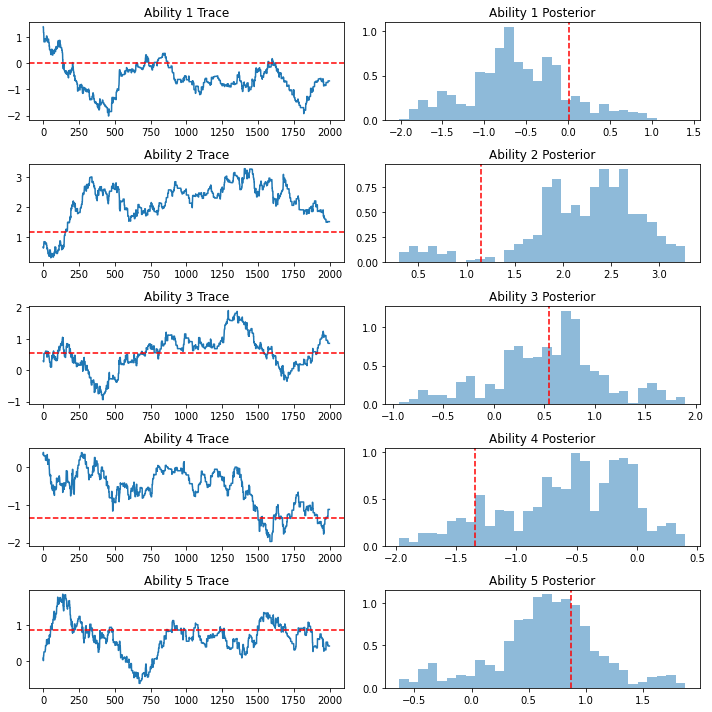

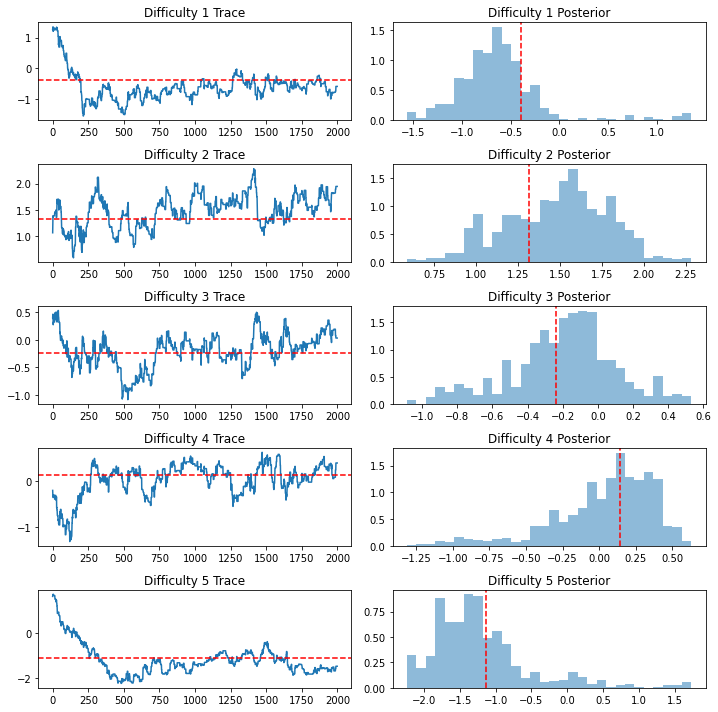

In [48]:
import numpy as np

# Number of students and questions
num_students = 100
num_questions = 20

# Simulated true abilities and difficulties (for generating data)
true_abilities = np.random.normal(loc=0, scale=1, size=num_students)
true_difficulties = np.random.normal(loc=0, scale=1, size=num_questions)

# Simulated student responses
responses = np.zeros((num_students, num_questions))
for i in range(num_students):
    for j in range(num_questions):
        p_correct = 1 / (1 + np.exp(-(true_abilities[i] - true_difficulties[j])))
        responses[i, j] = np.random.binomial(n=1, p=p_correct)

# Metropolis-Hastings MCMC
def metropolis_hastings(num_samples, proposal_std):
    abilities = np.random.normal(loc=0, scale=1, size=num_students)
    difficulties = np.random.normal(loc=0, scale=1, size=num_questions)
    samples = []

    for _ in range(num_samples):
        # Propose new samples
        new_abilities = abilities + np.random.normal(loc=0, scale=proposal_std, size=num_students)
        new_difficulties = difficulties + np.random.normal(loc=0, scale=proposal_std, size=num_questions)

        # Compute log likelihood for current and proposed samples
        log_likelihood_current = np.sum(responses * (abilities[:, None] - difficulties[None, :]) -
                                        np.logaddexp(0, abilities[:, None] - difficulties[None, :]))
        log_likelihood_new = np.sum(responses * (new_abilities[:, None] - new_difficulties[None, :]) -
                                    np.logaddexp(0, new_abilities[:, None] - new_difficulties[None, :]))

        # Compute acceptance ratio
        acceptance_ratio = np.exp(log_likelihood_new - log_likelihood_current)

        # Accept or reject the proposal
        if np.random.uniform(0, 1) < acceptance_ratio:
            abilities = new_abilities
            difficulties = new_difficulties

        samples.append((abilities.copy(), difficulties.copy()))

    return samples

num_samples = 2000
proposal_std = 0.1
samples = metropolis_hastings(num_samples, proposal_std)

# Extract abilities and difficulties
abilities_samples, difficulties_samples = zip(*samples)
abilities_samples = np.array(abilities_samples)
difficulties_samples = np.array(difficulties_samples)

# Compute posterior means
posterior_mean_abilities = np.mean(abilities_samples, axis=0)
posterior_mean_difficulties = np.mean(difficulties_samples, axis=0)


# Plotting
def plot_results(samples, true_values, param_name, num_to_plot=5):
    fig, axes = plt.subplots(num_to_plot, 2, figsize=(10, 2 * num_to_plot))
    for i in range(num_to_plot):
        # Trace Plot
        axes[i, 0].plot(samples[:, i])
        axes[i, 0].set_title(f'{param_name} {i + 1} Trace')
        axes[i, 0].axhline(y=true_values[i], color='r', linestyle='--')

        # Posterior Distribution
        axes[i, 1].hist(samples[:, i], bins=30, density=True, alpha=0.5)
        axes[i, 1].set_title(f'{param_name} {i + 1} Posterior')
        axes[i, 1].axvline(x=true_values[i], color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

# Plot results for the first few abilities and difficulties
plot_results(abilities_samples, true_abilities, 'Ability')
plot_results(difficulties_samples, true_difficulties, 'Difficulty')
